In [1]:
pip install torch


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%%capture
!kaggle datasets download -d vitvhong/uplink-sum-rate
!unzip uplink-sum-rate.zip -d ./uplink
%cd uplink

In [3]:
import numpy as np
import torch
from torch_geometric.loader import  DataLoader
from torch_geometric.data import HeteroData, Data, Dataset, Batch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [4]:
train_layouts = 2000
test_layouts = 100

In [5]:
import scipy.io
import numpy as np

file_names = ['cf_train_10_30_sum.mat', 'cf_train_20_50_sum.mat', 'cf_train_10_70_sum.mat', 'cf_train_20_100_sum.mat']
data_list = []

for file_name in file_names:
    data = scipy.io.loadmat(file_name)
    beta_samples = data['betas'][:train_layouts]
    direct_samples = data['directs'][:train_layouts]
    cross_samples = data['corsses'].transpose(0, 2, 1)[:train_layouts]

    data_list.append({
        'beta': beta_samples,
        'direct': direct_samples,
        'cross': cross_samples
    })

for i, file_data in enumerate(data_list):
    print(f"File {i + 1}:")
    print("Beta shape:", file_data['beta'].shape)
    print("Direct shape:", file_data['direct'].shape)
    print("Cross shape:", file_data['cross'].shape)
    print()


File 1:
Beta shape: (2000, 30, 10)
Direct shape: (2000, 10)
Cross shape: (2000, 10, 10)

File 2:
Beta shape: (2000, 50, 20)
Direct shape: (2000, 20)
Cross shape: (2000, 20, 20)

File 3:
Beta shape: (2000, 70, 10)
Direct shape: (2000, 10)
Cross shape: (2000, 10, 10)

File 4:
Beta shape: (2000, 100, 20)
Direct shape: (2000, 20)
Cross shape: (2000, 20, 20)



In [6]:
test_data = scipy.io.loadmat('30_10.mat')
beta_test = test_data['betas']
direct_test = test_data['directs']
cross_test = test_data['corsses'].transpose(0,2,1)
opt_rates = test_data['R_cf_opt_min']

In [8]:
np.mean(opt_rates)

12.72640071899708

In [7]:
def normalize_data(train_data,test_data):
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    return norm_train, norm_test
norm_train_losses_10_30, norm_test_losses = normalize_data(data_list[0]['beta']**(1/2), beta_test**(1/2) )
norm_train_losses_20_50, _ = normalize_data(data_list[1]['beta']**(1/2), beta_test**(1/2) )
norm_train_losses_10_70, _ = normalize_data(data_list[2]['beta']**(1/2), beta_test**(1/2) )
norm_train_losses_20_100, _ = normalize_data(data_list[3]['beta']**(1/2), beta_test**(1/2) )

In [8]:
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

In [9]:
class PCDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.get_cg()
        self.process()

    def build_graph(self, idx):
        edge_feature = self.norm_losses[idx, :, :].reshape((self.KM[0] * self.KM[1], 1), order='F')
        edge_feature = np.concatenate((edge_feature, np.ones_like(edge_feature)), axis=-1)
        edge_feature = torch.tensor(edge_feature, dtype=torch.float)

        edge_index = torch.tensor(self.adj, dtype=torch.long).t().contiguous()
        edge_index_t = torch.tensor(self.adj_t, dtype=torch.long).t().contiguous()
        ue_features = torch.ones((self.KM[0], 1))
        ap_features = torch.ones((self.KM[1], 1))

        data = HeteroData()
        data['UE'].x = ue_features
        data['AP'].x = ap_features
        data['UE', 'com-by', 'AP'].edge_index = edge_index
        data['UE', 'com-by', 'AP'].edge_attr = edge_feature
        data['AP', 'com', 'UE'].edge_index = edge_index_t
        data['AP', 'com', 'UE'].edge_attr = edge_feature

        return data

    def get_cg(self):
        self.adj = []
        self.adj_t = []
        for i in range(self.KM[0]):
            for j in range(self.KM[1]):
                self.adj.append([i, j])
                self.adj_t.append([j, i])

    def process(self):
        self.graph_list = [self.build_graph(i) for i in range(len(self.direct))]

    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.graph_list[index], self.direct[index], self.cross[index]

In [10]:
def collate(samples):
    '''Pytorch Geometric collate function'''
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = Batch.from_data_list(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

In [11]:
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

In [12]:
train_data_10_30 = PCDataset(norm_train_losses_10_30, data_list[0]['direct'], data_list[0]['cross'], (10, 30))
train_data_20_50 = PCDataset(norm_train_losses_20_50, data_list[1]['direct'], data_list[1]['cross'], (20, 50))
train_data_10_70 = PCDataset(norm_train_losses_10_70, data_list[2]['direct'], data_list[2]['cross'], (10, 70))
train_data_20_100 = PCDataset(norm_train_losses_20_100, data_list[3]['direct'], data_list[3]['cross'], (20, 100))

In [13]:
batch_size = 64
test_loader = DataLoader(test_data, test_layouts, shuffle=False, collate_fn=collate)
train_loader_10_30 = DataLoader(train_data_10_30, batch_size, shuffle=True, collate_fn=collate)
train_loader_20_50 = DataLoader(train_data_20_50, batch_size, shuffle=True, collate_fn=collate)
train_loader_10_70 = DataLoader(train_data_10_70, batch_size, shuffle=True, collate_fn=collate)
train_loader_20_100 = DataLoader(train_data_20_100, batch_size, shuffle=True, collate_fn=collate)

In [14]:
def sum_rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.sum(rates, dim = 1) # take sum
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

In [34]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(MessagePassing):
    def __init__(self, input_dim, node_dim, **kwargs):
        super(EdgeConv, self).__init__(aggr='mean')
        self.lin = MLP([input_dim, 32])
        self.res_lin = Lin(node_dim, 32)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        return aggr_out



In [35]:
class RGCN(nn.Module):
    def __init__(self):
        super(RGCN, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(4, 1),
            ('AP', 'com', 'UE'): EdgeConv(4, 1)
        }, aggr='sum')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='sum')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='sum')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [36]:
model = RGCN()

optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [37]:
def train(train_loader):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        K = d_train.shape[-1]
        n = len(data['UE'].x)
        bs = len(data['UE'].x) // K

        optimizer.zero_grad()
        user_feats = data['AP'].x
        item_feats = data['UE'].x
        node_features = {'AP': user_feats, 'UE': item_feats}
        output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

        loss = sum_rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * bs
        optimizer.step()

    return loss_all / len(train_loader.dataset)



In [38]:
def test(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data, d_test, c_test) in loader:
            K = d_test.shape[-1]
            n = len(data['UE'].x)
            bs = len(data['UE'].x) // K
            user_feats = data['AP'].x
            item_feats = data['UE'].x
            node_features = {'AP': user_feats, 'UE': item_feats}
            output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
            loss = sum_rate_loss(output, d_test, c_test)
            correct += loss.item() * bs

    return correct / len(loader.dataset)

In [22]:
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test(test_loader)
            train_rate = test(train_loader_20_50)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')

    train(train_loader_20_50)
    scheduler.step()


Epoch 000, Train Rate: -20.9381, Test Rate: -10.3113
Epoch 001, Train Rate: -20.9437, Test Rate: -10.3210
Epoch 002, Train Rate: -22.5321, Test Rate: -11.0721
Epoch 003, Train Rate: -22.9196, Test Rate: -11.3573
Epoch 004, Train Rate: -23.4441, Test Rate: -11.6269
Epoch 005, Train Rate: -23.6645, Test Rate: -11.7543
Epoch 006, Train Rate: -23.5009, Test Rate: -11.6966
Epoch 007, Train Rate: -23.3212, Test Rate: -11.6212
Epoch 008, Train Rate: -23.7072, Test Rate: -11.8124
Epoch 009, Train Rate: -23.3518, Test Rate: -11.6636
Epoch 010, Train Rate: -23.8204, Test Rate: -11.9139
Epoch 011, Train Rate: -23.3906, Test Rate: -11.6725
Epoch 012, Train Rate: -23.8588, Test Rate: -11.8654
Epoch 013, Train Rate: -23.9262, Test Rate: -11.9707
Epoch 014, Train Rate: -24.0043, Test Rate: -12.0066
Epoch 015, Train Rate: -23.3292, Test Rate: -11.6109
Epoch 016, Train Rate: -24.2018, Test Rate: -12.1033
Epoch 017, Train Rate: -23.2270, Test Rate: -11.5798
Epoch 018, Train Rate: -23.5883, Test Rate: -1

In [23]:
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test(test_loader)
            train_rate = test(train_loader_10_70)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')

    train(train_loader_10_70)
    scheduler.step()


Epoch 000, Train Rate: -17.7068
Epoch 001, Train Rate: -18.0315
Epoch 002, Train Rate: -18.1851
Epoch 003, Train Rate: -18.1736
Epoch 004, Train Rate: -18.2943
Epoch 005, Train Rate: -18.1686
Epoch 006, Train Rate: -18.2024
Epoch 007, Train Rate: -18.0939
Epoch 008, Train Rate: -18.2756
Epoch 009, Train Rate: -17.8702
Epoch 010, Train Rate: -18.1516
Epoch 011, Train Rate: -18.2802
Epoch 012, Train Rate: -18.2469
Epoch 013, Train Rate: -18.1846
Epoch 014, Train Rate: -18.2176
Epoch 015, Train Rate: -18.2043
Epoch 016, Train Rate: -18.2251
Epoch 017, Train Rate: -18.2923
Epoch 018, Train Rate: -18.2859
Epoch 019, Train Rate: -18.2777
Epoch 020, Train Rate: -18.2919
Epoch 021, Train Rate: -18.2674
Epoch 022, Train Rate: -18.2766
Epoch 023, Train Rate: -18.2630
Epoch 024, Train Rate: -18.2853
Epoch 025, Train Rate: -18.2462
Epoch 026, Train Rate: -18.2765
Epoch 027, Train Rate: -18.2759
Epoch 028, Train Rate: -18.2845
Epoch 029, Train Rate: -18.2415


In [24]:
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test(train_loader_20_100)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')

    train(train_loader_20_100)
    scheduler.step()


Epoch 000, Train Rate: -34.9626
Epoch 001, Train Rate: -35.0503
Epoch 002, Train Rate: -35.0943
Epoch 003, Train Rate: -34.9618
Epoch 004, Train Rate: -35.0041
Epoch 005, Train Rate: -35.0510
Epoch 006, Train Rate: -35.0911
Epoch 007, Train Rate: -35.0461
Epoch 008, Train Rate: -35.0739
Epoch 009, Train Rate: -35.1075
Epoch 010, Train Rate: -35.0876
Epoch 011, Train Rate: -35.0728
Epoch 012, Train Rate: -35.0499
Epoch 013, Train Rate: -35.0891
Epoch 014, Train Rate: -35.0583
Epoch 015, Train Rate: -35.0697
Epoch 016, Train Rate: -35.0843
Epoch 017, Train Rate: -35.0297
Epoch 018, Train Rate: -35.0495
Epoch 019, Train Rate: -35.0468
Epoch 020, Train Rate: -35.0930
Epoch 021, Train Rate: -35.0903
Epoch 022, Train Rate: -35.0818
Epoch 023, Train Rate: -35.0282
Epoch 024, Train Rate: -35.0744
Epoch 025, Train Rate: -35.0830
Epoch 026, Train Rate: -35.0644
Epoch 027, Train Rate: -35.0414
Epoch 028, Train Rate: -35.0786
Epoch 029, Train Rate: -35.0660


In [25]:
opt = []
gnn = []

for i in range(30,101,10):
  open_file = str(i) + '_10.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_min']
  opt.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (10, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  q = -test(loader)
  gnn.append(q)



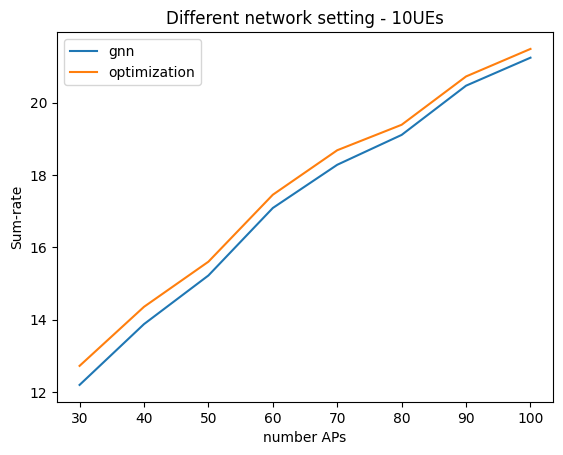

In [26]:
import matplotlib.pyplot as plt

x_values = list(range(30, 101, 10))

plt.plot(x_values, gnn, label='gnn')
plt.plot(x_values, opt, label='optimization')
plt.title('Different network setting - 10UEs')
plt.xlabel('number APs')
plt.ylabel('Sum-rate')


plt.legend()
plt.show()

In [27]:
opt_20 = []
gnn_20 = []

for i in range(30,101,10):
  open_file = str(i) + '_20.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_min']
  opt_20.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (20, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  q = -test(loader)
  gnn_20.append(q)



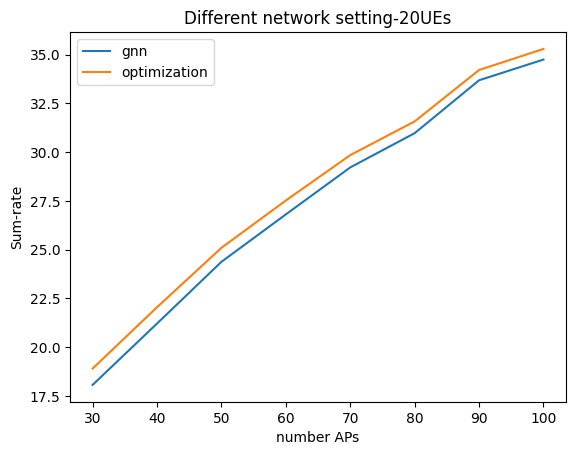

In [28]:
import matplotlib.pyplot as plt

x_values = list(range(30, 101, 10))

plt.plot(x_values, gnn_20, label='gnn')
plt.plot(x_values, opt_20, label='optimization')


plt.title('Different network setting-20UEs')
plt.xlabel('number APs')
plt.ylabel('Sum-rate')


plt.legend()
plt.show()

In [29]:
-test(test_loader)

12.198236465454102

In [30]:
np.mean(opt_rates)

12.72640071899708

#HQGNN

In [17]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [39]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits)}

In [40]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits)}

In [41]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [42]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2**n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')


        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [43]:
model_qml_mid = RGCN_Hybrid_mid().to()

optimizer_qml_mid = torch.optim.Adam(model_qml_mid.parameters(), lr=5e-4)
scheduler_qml_mid = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid, step_size=10, gamma=0.4)

In [44]:
def train_model(epoch, model, optimizer, train_loader):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        K = d_train.shape[-1]
        n = len(data['UE'].x)
        bs = len(data['UE'].x) // K

        optimizer.zero_grad()
        user_feats = data['AP'].x
        item_feats = data['UE'].x
        node_features = {'AP': user_feats, 'UE': item_feats}
        output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

        loss = sum_rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * bs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

def test_model(loader, model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data, d_test, c_test) in loader:
            K = d_test.shape[-1]
            n = len(data['UE'].x)
            bs = len(data['UE'].x) // K

            user_feats = data['AP'].x
            item_feats = data['UE'].x
            node_features = {'AP': user_feats, 'UE': item_feats}

            output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

            loss = sum_rate_loss(output, d_test, c_test)
            correct += loss.item() * bs

    return correct / len(loader.dataset)

In [39]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_50, model_qml_mid)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid, optimizer_qml_mid, train_loader_20_50)
    scheduler_qml_mid.step()

Epoch 000, Train Rate: -20.9274
Epoch 001, Train Rate: -20.9062
Epoch 002, Train Rate: -20.5880
Epoch 003, Train Rate: -21.4930
Epoch 004, Train Rate: -22.1978
Epoch 005, Train Rate: -21.9306
Epoch 006, Train Rate: -18.0349
Epoch 007, Train Rate: -20.3434
Epoch 008, Train Rate: -21.6004
Epoch 009, Train Rate: -22.6029
Epoch 010, Train Rate: -22.7232
Epoch 011, Train Rate: -24.1257
Epoch 012, Train Rate: -23.9064
Epoch 013, Train Rate: -24.1618
Epoch 014, Train Rate: -24.1138
Epoch 015, Train Rate: -23.9658
Epoch 016, Train Rate: -23.8941
Epoch 017, Train Rate: -24.0633
Epoch 018, Train Rate: -24.2723
Epoch 019, Train Rate: -23.9239
Epoch 020, Train Rate: -23.1267
Epoch 021, Train Rate: -23.7833
Epoch 022, Train Rate: -24.0729
Epoch 023, Train Rate: -24.5674
Epoch 024, Train Rate: -23.9678
Epoch 025, Train Rate: -24.0538
Epoch 026, Train Rate: -24.5650
Epoch 027, Train Rate: -24.3122
Epoch 028, Train Rate: -24.6346
Epoch 029, Train Rate: -24.5675


In [40]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_10_70, model_qml_mid)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid, optimizer_qml_mid, train_loader_10_70)
    scheduler_qml_mid.step()

Epoch 000, Train Rate: -18.0564
Epoch 001, Train Rate: -18.2612
Epoch 002, Train Rate: -18.2060
Epoch 003, Train Rate: -18.3444
Epoch 004, Train Rate: -18.3437
Epoch 005, Train Rate: -18.3510
Epoch 006, Train Rate: -18.3472
Epoch 007, Train Rate: -18.2948
Epoch 008, Train Rate: -18.3250
Epoch 009, Train Rate: -18.3226
Epoch 010, Train Rate: -18.2208
Epoch 011, Train Rate: -18.3622
Epoch 012, Train Rate: -18.3718
Epoch 013, Train Rate: -18.3730
Epoch 014, Train Rate: -18.3694
Epoch 015, Train Rate: -18.3706
Epoch 016, Train Rate: -18.3588
Epoch 017, Train Rate: -18.3560
Epoch 018, Train Rate: -18.3519
Epoch 019, Train Rate: -18.3740
Epoch 020, Train Rate: -18.3653
Epoch 021, Train Rate: -18.3756
Epoch 022, Train Rate: -18.3746
Epoch 023, Train Rate: -18.3759
Epoch 024, Train Rate: -18.3664
Epoch 025, Train Rate: -18.3740
Epoch 026, Train Rate: -18.3755
Epoch 027, Train Rate: -18.3754
Epoch 028, Train Rate: -18.3751
Epoch 029, Train Rate: -18.3751


In [41]:
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_100, model_qml_mid)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid, optimizer_qml_mid, train_loader_20_100)
    scheduler_qml_mid.step()

Epoch 000, Train Rate: -35.1050
Epoch 001, Train Rate: -35.1033
Epoch 002, Train Rate: -35.1222
Epoch 003, Train Rate: -35.1326
Epoch 004, Train Rate: -35.1340
Epoch 005, Train Rate: -35.1401
Epoch 006, Train Rate: -35.1398
Epoch 007, Train Rate: -35.1441
Epoch 008, Train Rate: -35.1476
Epoch 009, Train Rate: -35.1481
Epoch 010, Train Rate: -35.1453
Epoch 011, Train Rate: -35.1526
Epoch 012, Train Rate: -35.1461
Epoch 013, Train Rate: -35.1457
Epoch 014, Train Rate: -35.1462
Epoch 015, Train Rate: -35.1548
Epoch 016, Train Rate: -35.1482
Epoch 017, Train Rate: -35.1512
Epoch 018, Train Rate: -35.1539
Epoch 019, Train Rate: -35.1544
Epoch 020, Train Rate: -35.1367
Epoch 021, Train Rate: -35.1454
Epoch 022, Train Rate: -35.1545
Epoch 023, Train Rate: -35.1481
Epoch 024, Train Rate: -35.1485
Epoch 025, Train Rate: -35.1563
Epoch 026, Train Rate: -35.1526
Epoch 027, Train Rate: -35.1534
Epoch 028, Train Rate: -35.1571
Epoch 029, Train Rate: -35.1581


In [43]:
opt_20 = []
qgnn_20 = []
for i in range(30,101,10):
  open_file = str(i) + '_20.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_min']
  opt_20.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (20, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  q = -test_model(loader, model_qml_mid)
  qgnn_20.append(q)

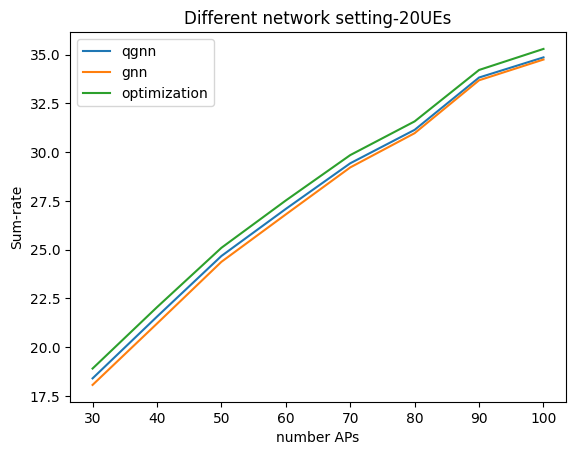

In [44]:
import matplotlib.pyplot as plt

x_values = list(range(30, 101, 10))

plt.plot(x_values, qgnn_20, label='qgnn')
plt.plot(x_values, gnn_20, label='gnn')
plt.plot(x_values, opt_20, label='optimization')


plt.title('Different network setting-20UEs')
plt.xlabel('number APs')
plt.ylabel('Sum-rate')


plt.legend()
plt.show()

In [45]:
torch.save(model.state_dict(), 'model_sum.pth')
torch.save(model_qml_mid.state_dict(), 'model_amplitude_sum.pth')

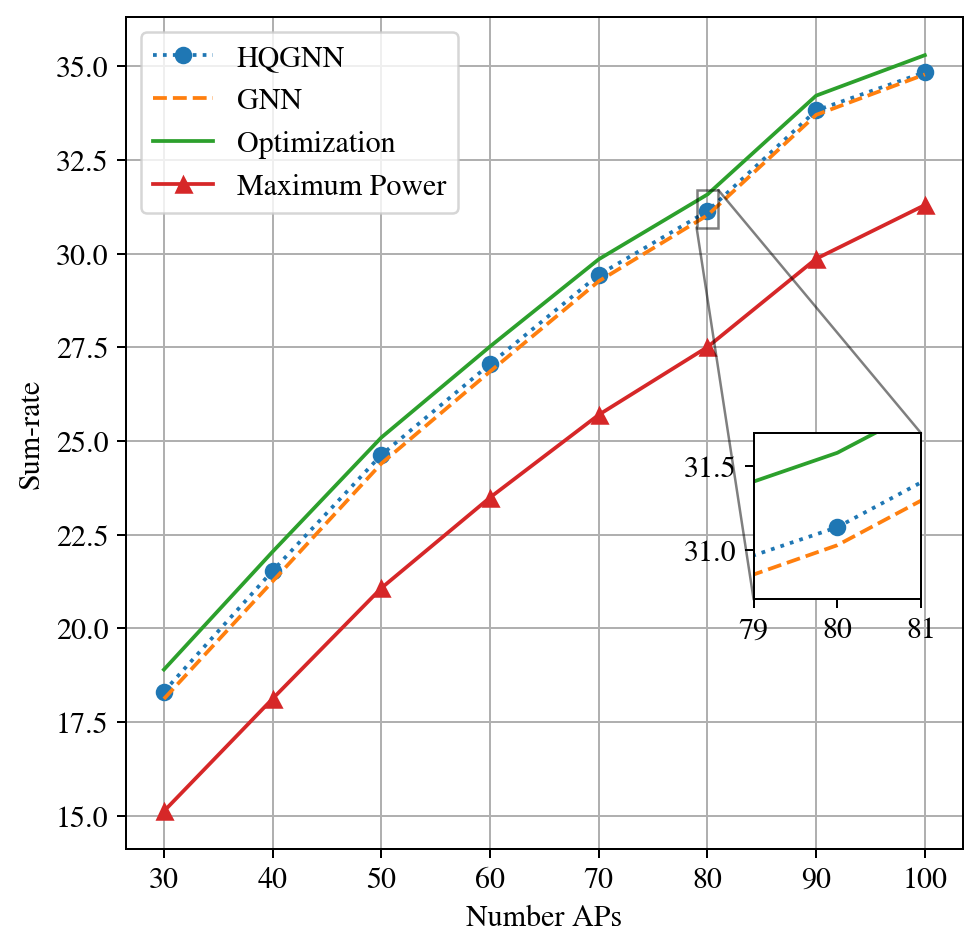

In [46]:
opt_20 = []
qgnn_20 = []
gnn_20 = []
all_one_rates_20 = []
for i in range(30,101,10):
  open_file = str(i) + '_20.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_min']
  opt_20.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (20, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  for (data, d_test, c_test) in loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output1 = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    gnn_rates = -sum_rate_loss(output1, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
  gnn_20.append(gnn_rates)
  qgnn_20.append(qgnn_rates)
  all_one_rates_20.append(all_one)

import matplotlib.pyplot as plt


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})


fig, ax = plt.subplots(figsize=(6, 6), dpi=180)
x_values = list(range(30, 101, 10))

ax.plot(x_values, qgnn_20, label='HQGNN', linestyle=':', marker='o')  
ax.plot(x_values, gnn_20, label='GNN', linestyle='--')
ax.plot(x_values, opt_20, label='Optimization', linestyle='-') 
ax.plot(x_values, all_one_rates_20, label='Maximum Power', linestyle='-', marker='^')


ax.set_xlabel('Number APs')
ax.set_ylabel('Sum-rate')


ax.legend()
ax.grid()


x1, x2, y1, y2 = 79, 81, 30.7, 31.7


axins = ax.inset_axes([0.75, 0.3, 0.2, 0.2])


axins.plot(x_values, qgnn_20, label='HQGNN', linestyle=':', marker='o')
axins.plot(x_values, gnn_20, label='GNN', linestyle='--')
axins.plot(x_values, opt_20, label='Optimization', linestyle='-')
axins.plot(x_values, all_one_rates_20, label='Maximum Power', linestyle='-', marker='^')


axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)


ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()


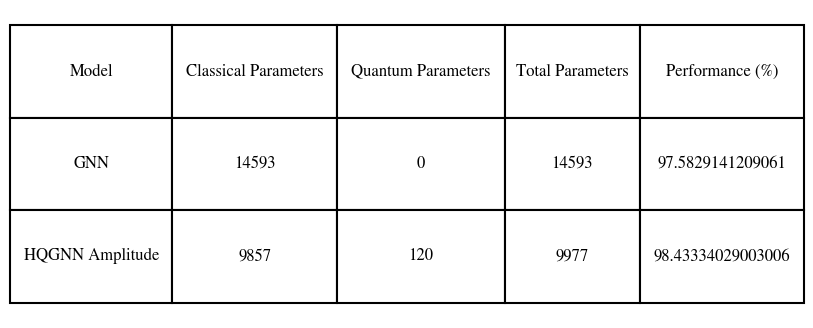

In [48]:
import pandas as pd
import matplotlib.pyplot as plt


def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  
            quantum_params += param.numel()
        else:  
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_mid,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}



avg_gnn_test_rates_amplitude = np.mean(qgnn_20)
avg_gnn_test_rates = np.mean(gnn_20)
opt_rates = np.mean(opt_20)
    
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
}


data = {
    "Model": ["GNN", "HQGNN Amplitude"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0]],
    "Total Parameters": [params_count["GNN"][0] + params_count["GNN"][1],params_count["HQGNN Amplitude"][0]+params_count["HQGNN Amplitude"][1]],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"]],
}
params_df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')  
ax.axis('off')  
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')


table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)  # Độ dày đường kẻ
    cell.set_height(0.3)    # Tăng chiều cao hàng
    cell.set_width(0.25) 

# Hiển thị bảng
plt.savefig("model_parameters_table_from_code.png", dpi=300, bbox_inches='tight')
plt.show()


In [77]:
torch.save(model.state_dict(), 'model_sum.pth')
torch.save(model_qml_mid.state_dict(), 'model_amp_sum.pth')

In [19]:
n_layers_circuit_X2 = 4
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [20]:
n_layers_circuit_Z2 = 4
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [21]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [22]:
class RGCN_Hybrid_mid_angle(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid_angle, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [23]:
model_qml_mid_angle = RGCN_Hybrid_mid_angle().to()

optimizer_qml_mid_angle = torch.optim.Adam(model_qml_mid_angle.parameters(), lr=5e-4)
scheduler_qml_mid_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid_angle, step_size=10, gamma=0.4)

In [24]:
trainable_params = sum(p.numel() for p in model_qml_mid_angle.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3271


In [27]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_50, model_qml_mid_angle)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader_20_50)
    scheduler_qml_mid_angle.step()

Epoch 000, Train Rate: -20.9285
Epoch 001, Train Rate: -20.9241
Epoch 002, Train Rate: -21.1595
Epoch 003, Train Rate: -23.0941
Epoch 004, Train Rate: -23.7646
Epoch 005, Train Rate: -23.9555
Epoch 006, Train Rate: -24.1664
Epoch 007, Train Rate: -24.3263
Epoch 008, Train Rate: -24.3718
Epoch 009, Train Rate: -23.9200
Epoch 010, Train Rate: -24.0506
Epoch 011, Train Rate: -24.3840
Epoch 012, Train Rate: -24.4253
Epoch 013, Train Rate: -24.3733
Epoch 014, Train Rate: -24.4833
Epoch 015, Train Rate: -24.5088
Epoch 016, Train Rate: -24.4769
Epoch 017, Train Rate: -24.5438
Epoch 018, Train Rate: -24.5297
Epoch 019, Train Rate: -24.5329
Epoch 020, Train Rate: -24.5068
Epoch 021, Train Rate: -24.5691
Epoch 022, Train Rate: -24.5713
Epoch 023, Train Rate: -24.5882
Epoch 024, Train Rate: -24.5998
Epoch 025, Train Rate: -24.5712
Epoch 026, Train Rate: -24.5775
Epoch 027, Train Rate: -24.5736
Epoch 028, Train Rate: -24.5937
Epoch 029, Train Rate: -24.5877


In [29]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_10_70, model_qml_mid_angle)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader_10_70)
    scheduler_qml_mid_angle.step()

Epoch 000, Train Rate: -18.3131
Epoch 001, Train Rate: -18.3287
Epoch 002, Train Rate: -18.3278
Epoch 003, Train Rate: -18.3347
Epoch 004, Train Rate: -18.3388
Epoch 005, Train Rate: -18.3390
Epoch 006, Train Rate: -18.3427
Epoch 007, Train Rate: -18.3447
Epoch 008, Train Rate: -18.3465
Epoch 009, Train Rate: -18.3448
Epoch 010, Train Rate: -18.3435
Epoch 011, Train Rate: -18.3462
Epoch 012, Train Rate: -18.3462
Epoch 013, Train Rate: -18.3464
Epoch 014, Train Rate: -18.3498
Epoch 015, Train Rate: -18.3438
Epoch 016, Train Rate: -18.3379
Epoch 017, Train Rate: -18.3476
Epoch 018, Train Rate: -18.3451
Epoch 019, Train Rate: -18.3426
Epoch 020, Train Rate: -18.3431
Epoch 021, Train Rate: -18.3442
Epoch 022, Train Rate: -18.3420
Epoch 023, Train Rate: -18.3392
Epoch 024, Train Rate: -18.3465
Epoch 025, Train Rate: -18.3488
Epoch 026, Train Rate: -18.3497
Epoch 027, Train Rate: -18.3513
Epoch 028, Train Rate: -18.3383
Epoch 029, Train Rate: -18.3459


In [30]:
record = []
for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            train_rate = test_model(train_loader_20_100, model_qml_mid_angle)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}')
        record.append(train_rate)

    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader_20_100)
    scheduler_qml_mid_angle.step()

Epoch 000, Train Rate: -35.1176
Epoch 001, Train Rate: -35.1045
Epoch 002, Train Rate: -35.1292
Epoch 003, Train Rate: -35.1136
Epoch 004, Train Rate: -35.1392
Epoch 005, Train Rate: -35.1251
Epoch 006, Train Rate: -35.1443
Epoch 007, Train Rate: -35.1389
Epoch 008, Train Rate: -35.1238
Epoch 009, Train Rate: -35.1391
Epoch 010, Train Rate: -35.1553
Epoch 011, Train Rate: -35.1507
Epoch 012, Train Rate: -35.1417
Epoch 013, Train Rate: -35.1357
Epoch 014, Train Rate: -35.1323
Epoch 015, Train Rate: -35.1471
Epoch 016, Train Rate: -35.1312
Epoch 017, Train Rate: -35.1557
Epoch 018, Train Rate: -35.1329
Epoch 019, Train Rate: -35.1449
Epoch 020, Train Rate: -35.1560
Epoch 021, Train Rate: -35.1359
Epoch 022, Train Rate: -35.1558
Epoch 023, Train Rate: -35.1469
Epoch 024, Train Rate: -35.1538
Epoch 025, Train Rate: -35.1368
Epoch 026, Train Rate: -35.1395
Epoch 027, Train Rate: -35.1645
Epoch 028, Train Rate: -35.1396
Epoch 029, Train Rate: -35.1421


In [50]:
angle_qgnn_20 = []
opt_20 = []
all_one_rates_20 = []
random_rates = []
for i in range(30,101,10):
  open_file = str(i) + '_20.mat'
  data = scipy.io.loadmat(open_file)
  beta = data['betas']
  direct = data['directs']
  cross = data['corsses'].transpose(0,2,1)
  opti = data['R_cf_opt_min']
  opt_20.append(np.mean(opti))
  _, norm_losses = normalize_data(beta**(1/2), beta**(1/2))
  data = PCDataset(norm_losses, direct, cross, (20, i))
  loader = DataLoader(data, 100, shuffle=False, collate_fn=collate)
  for (data, d_test, c_test) in loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K

    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}

    output = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    full = torch.ones_like(output)
    random = torch.rand_like(output)
    qgnn_rates = -sum_rate_loss(output, d_test, c_test).detach().numpy()
    all_one = -sum_rate_loss(full, d_test, c_test).detach().numpy()
    rand_rates = -sum_rate_loss(random, d_test, c_test).detach().numpy()
    
  
  angle_qgnn_20.append(qgnn_rates)
  all_one_rates_20.append(all_one)
  random_rates.append(rand_rates)


In [31]:
torch.save(model_qml_mid_angle.state_dict(), 'model_angle_sum.pth')

In [45]:
model.load_state_dict(torch.load('model_sum.pth'))
model_qml_mid.load_state_dict(torch.load('model_amp_sum.pth'))

<All keys matched successfully>

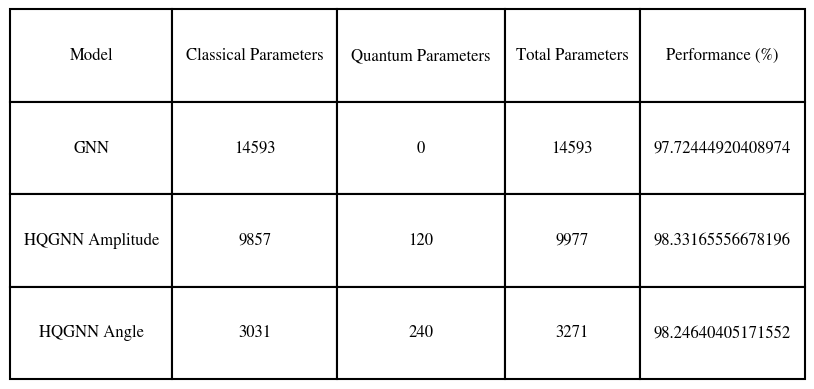

In [47]:
import pandas as pd
import matplotlib.pyplot as plt


def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  
            quantum_params += param.numel()
        else:  
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_mid,
    "HQGNN Angle": model_qml_mid_angle,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}



avg_gnn_test_rates_amplitude = np.mean(qgnn_20)
avg_gnn_test_rates = np.mean(gnn_20)
opt_rates = np.mean(opt_20)
avg_gnn_test_rates_angle = np.mean(angle_qgnn_20)
    
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates)*100,
}


data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0],params_count["HQGNN Angle"][0]],
    "Total Parameters": [params_count["GNN"][0] + params_count["GNN"][1],params_count["HQGNN Amplitude"][0]+params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1] + params_count["HQGNN Angle"][0]],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"]],
}
params_df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')  
ax.axis('off')  
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')


table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)  # Độ dày đường kẻ
    cell.set_height(0.3)    # Tăng chiều cao hàng
    cell.set_width(0.25) 

# Hiển thị bảng
plt.savefig("model_parameters_table_from_code.png", dpi=300, bbox_inches='tight')
plt.show()


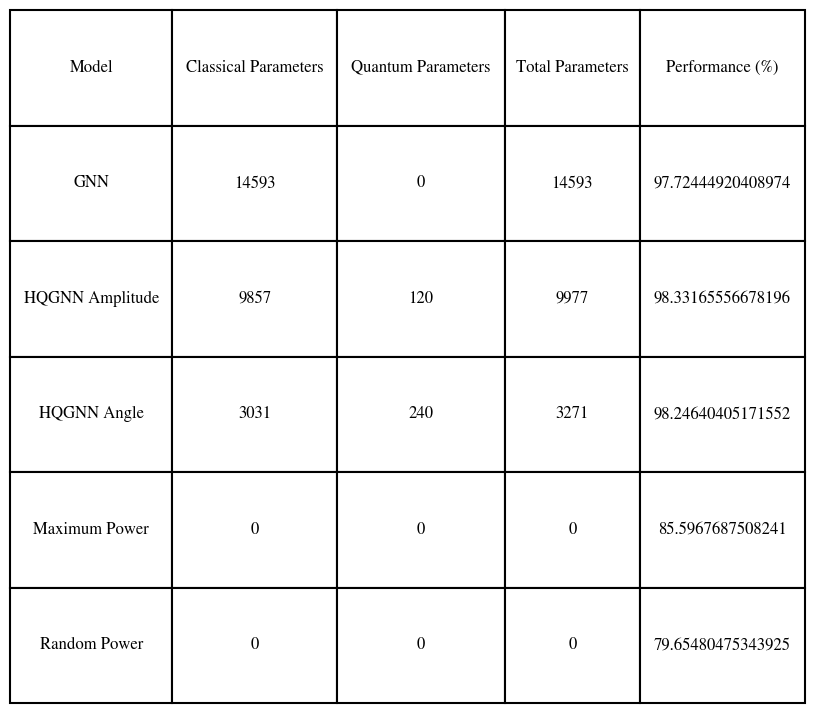

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  
            quantum_params += param.numel()
        else:  
            classical_params += param.numel()
    return quantum_params, classical_params

# Models to analyze
models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_mid,
    "HQGNN Angle": model_qml_mid_angle,
}

# Compute parameter counts
params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}

# Performance metrics
avg_gnn_test_rates = np.mean(gnn_20)
avg_gnn_test_rates_amplitude = np.mean(qgnn_20)
avg_gnn_test_rates_angle = np.mean(angle_qgnn_20)
opt_rates = np.mean(opt_20)
all_one_rates = np.mean(all_one_rates_20)
rand_rates = np.mean(random_rates)

performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
    "Maximum Power": (all_one_rates / opt_rates) * 100,
    "Random Power": (rand_rates / opt_rates) * 100
}

# Combine data into a DataFrame
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle", "Maximum Power", "Random Power"],
    "Classical Parameters": [
        params_count["GNN"][1], 
        params_count["HQGNN Amplitude"][1], 
        params_count["HQGNN Angle"][1], 
        0, 
        0
    ],
    "Quantum Parameters": [
        params_count["GNN"][0], 
        params_count["HQGNN Amplitude"][0], 
        params_count["HQGNN Angle"][0], 
        0, 
        0
    ],
    "Total Parameters": [
        params_count["GNN"][0] + params_count["GNN"][1], 
        params_count["HQGNN Amplitude"][0] + params_count["HQGNN Amplitude"][1], 
        params_count["HQGNN Angle"][0] + params_count["HQGNN Angle"][1], 
        0, 
        0
    ],
    "Performance (%)": [
        performance_percentages["GNN"], 
        performance_percentages["HQGNN Amplitude"], 
        performance_percentages["HQGNN Angle"], 
        performance_percentages["Maximum Power"], 
        performance_percentages["Random Power"]
    ],
}

params_df = pd.DataFrame(data)

# Visualize the data as a table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)
    cell.set_height(0.3)
    cell.set_width(0.25)

# Save and display the table
plt.savefig("model_parameters_table_combined.png", dpi=300, bbox_inches='tight')
plt.show()


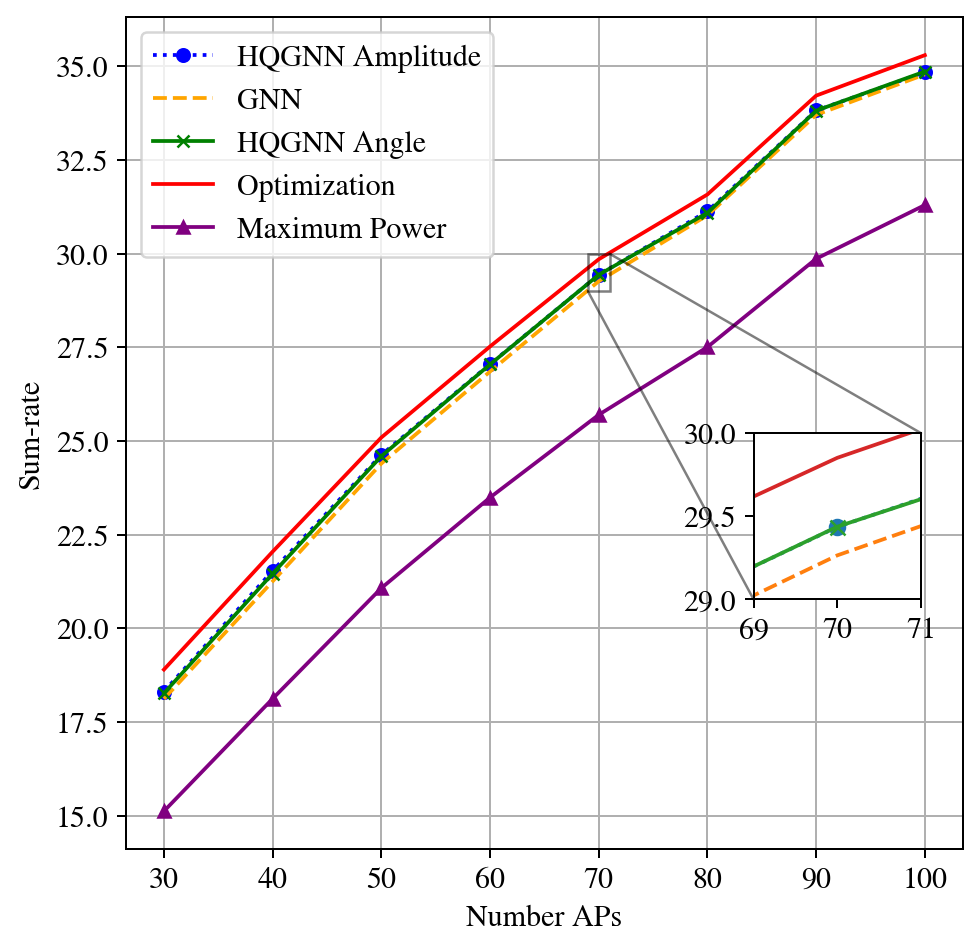

In [48]:
import matplotlib.pyplot as plt


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})


fig, ax = plt.subplots(figsize=(6, 6), dpi=180)
x_values = list(range(30, 101, 10))

ax.plot(x_values, qgnn_20, label='HQGNN Amplitude', color='blue', linestyle=':', marker='o', markersize=5)  
ax.plot(x_values, gnn_20, label='GNN', color='orange', linestyle='--', markersize=5)
ax.plot(x_values, angle_qgnn_20, label='HQGNN Angle', color='green', linestyle='-', marker='x', markersize=5)
ax.plot(x_values, opt_20, label='Optimization', color='red', linestyle='-')
ax.plot(x_values, all_one_rates_20, label='Maximum Power', color='purple', marker='^', markersize=5)


ax.set_xlabel('Number APs')
ax.set_ylabel('Sum-rate')


ax.legend()
ax.grid()


x1, x2, y1, y2 = 69, 71, 29, 30


axins = ax.inset_axes([0.75, 0.3, 0.2, 0.2])


axins.plot(x_values, qgnn_20, label='HQGNN Amplitude', linestyle=':', marker='o')
axins.plot(x_values, gnn_20, label='GNN', linestyle='--')
axins.plot(x_values, angle_qgnn_20, label='HQGNN Angle', marker='x')
axins.plot(x_values, opt_20, label='Optimization', linestyle='-')
axins.plot(x_values, all_one_rates_20, label='Maximum Power', linestyle='-', marker='^')


axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)


ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()
